In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import math
import copy
import time
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline
print(torch.__version__)

2.8.0+cu126


In [ ]:
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

y = train_df['label']
X = train_df.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = True)

num_epoch = 25
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.002
momentum = 0.9
log_interval = 100

In [ ]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#CustomDatasetFromDF
class MNISTDataset(Dataset):
    def __init__(self,  data, target, train=True, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.train = train
        if self.train :
            self.data = data
            self.labels = np.asarray(target.iloc[:])
        else:
            self.data = data
            self.labels = None
        self.height = 28 # Height of image
        self.width = 28 # Width of image
        self.transform = transform

    def __getitem__(self, index):
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][0:]).reshape(self.height, self.width).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        img_as_tensor = img_as_img

        if self.train:
            single_image_label = self.labels[index]
        else:
            single_image_label = None

        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)

        if self.train:
        # Return image and the label
            return (img_as_tensor, single_image_label)
        else:
            return img_as_tensor

    def __len__(self):
        return len(self.data.index)

In [ ]:
def calculate_img_stats_full(dataset):
    imgs_ = torch.stack([img for img,_ in dataset],dim=1)
    imgs_ = imgs_.view(1,-1)
    imgs_mean = imgs_.mean(dim=1)
    imgs_std = imgs_.std(dim=1)
    return imgs_mean,imgs_std

In [ ]:
transformations_train = transforms.Compose([transforms.RandomRotation(15),
                                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1310], std=[0.3085])
                                           ])


transformations_valid = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1310], std=[0.3085])
                                           ])

train = MNISTDataset(X_train, y_train, True, transformations_train)
valid = MNISTDataset(X_test, y_test, True, transformations_valid)
test  = MNISTDataset(data=test_df, target=None, train=False, transform=transformations_valid)

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size_train,num_workers=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size_test, num_workers=2, shuffle=True)
test_loader  = DataLoader(test,  batch_size=batch_size_test, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

In [ ]:
cnn_model = Net()
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    cnn_model.cuda()
    criterion.cuda()

optimizer = optim.Adam(params=cnn_model.parameters(), lr=learning_rate)

exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(1, num_epoch + 1)]

best_model_wts = copy.deepcopy(cnn_model.state_dict())
best_acc = 0.0

since = time.time()

for epoch in range(1, num_epoch + 1):
    cnn_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = cnn_model(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        if (i + 1)% log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i + 1) * len(images), len(train_loader.dataset),
                100. * (i + 1) / len(train_loader), loss.data))
            train_losses.append(loss.item())
            train_counter.append((i*64) + ((epoch-1)*len(train_loader.dataset)))
    cnn_model.eval()
    loss = 0
    running_corrects = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(valid_loader):
            data = Variable(data).cuda()
            target = Variable(target).cuda()
            output = cnn_model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()
            _, preds = torch.max(output, 1)
            running_corrects += torch.sum(preds == target.data)
    loss /= len(valid_loader.dataset)
    test_losses.append(loss)
    epoch_acc = 100. * running_corrects.double() / len(valid_loader.dataset)
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, running_corrects, len(valid_loader.dataset), epoch_acc))
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(cnn_model.state_dict())
    exp_lr_scheduler.step(loss)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Train Epoch: 1 [3200/35700 (9%)]	Loss: 0.973361
Train Epoch: 1 [6400/35700 (18%)]	Loss: 0.676897
Train Epoch: 1 [9600/35700 (27%)]	Loss: 0.441877
Train Epoch: 1 [12800/35700 (36%)]	Loss: 0.450620
Train Epoch: 1 [16000/35700 (45%)]	Loss: 0.517083
Train Epoch: 1 [19200/35700 (54%)]	Loss: 0.604903
Train Epoch: 1 [22400/35700 (63%)]	Loss: 0.128109
Train Epoch: 1 [25600/35700 (72%)]	Loss: 0.218379
Train Epoch: 1 [28800/35700 (81%)]	Loss: 0.186130
Train Epoch: 1 [32000/35700 (90%)]	Loss: 0.176297
Train Epoch: 1 [35200/35700 (99%)]	Loss: 0.337808

Average Val Loss: 0.0533, Val Accuracy: 6195/6300 (98.333%)

Train Epoch: 2 [3200/35700 (9%)]	Loss: 0.239725
Train Epoch: 2 [6400/35700 (18%)]	Loss: 0.470119
Train Epoch: 2 [9600/35700 (27%)]	Loss: 0.149414
Train Epoch: 2 [12800/35700 (36%)]	Loss: 0.144658
Train Epoch: 2 [16000/35700 (45%)]	Loss: 0.317977
Train Epoch: 2 [19200/35700 (54%)]	Loss: 0.555922
Train Epoch: 2 [22400/35700 (63%)]	Loss: 0.180693
Train Epoch: 2 [25600/35700 (72%)]	Loss: 0.252

Text(0, 0.5, 'negative log likelihood loss')

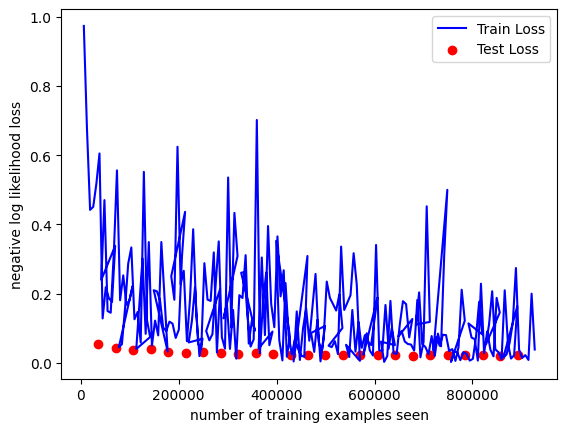

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
cnn_model.eval()
test_preds = None
test_preds = torch.LongTensor()

for i, data in enumerate(test_loader):
    data = Variable(data).cuda()
    output = cnn_model(data)
    preds = output.cpu().data.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, preds), dim=0)
print(test_preds)

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]])


In [ ]:
cnn_model.load_state_dict(best_model_wts)
cnn_model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in valid_loader:
        data = data.cuda()
        target = target.cuda()
        output = cnn_model(data)
        preds = torch.max(output, 1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       623
           1       1.00      1.00      1.00       676
           2       1.00      1.00      1.00       634
           3       1.00      1.00      1.00       606
           4       0.99      0.99      0.99       629
           5       1.00      0.99      0.99       602
           6       0.99      1.00      1.00       628
           7       1.00      1.00      1.00       665
           8       0.99      1.00      1.00       648
           9       0.98      1.00      0.99       589

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



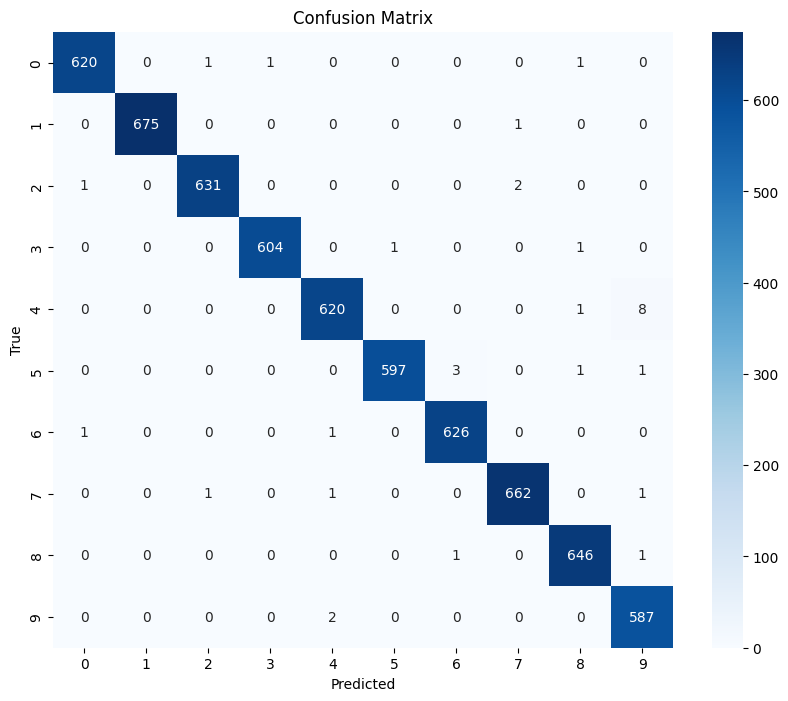

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Classification Report:")
print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from torchsummary import summary
summary(cnn_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Dropout-12                 [-1, 6272]               0
           Linear-13                  [-1, 128]         802,944
      BatchNorm1d-14                  [